# Introduction


In this project, I implement image-to-image translation from human selfies to anime faces using CycleGan.

In [14]:
# Imports
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as T
from torchvision import datasets
import random
import matplotlib.pyplot as plt
import albumentations as A


## Data Preparation / Loading

In this section I create dataloaders for the real and anime selfies. I also pre-process the data by resizing each image to be 128 x 128 in order to reduce computation time.

In [38]:
# Hyperparameters for the Loaders
BATCH_SIZE = 1
NUM_WORKERS = 2

# Resize each image to be 128 x 128 and transform it into a pytorch tensor
transformations = A.Compose(
            [A.Resize(width=128, height=128),
             A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
             A.pytorch.ToTensorV2(),
            ])

# Creating training, testing, and validation datasets for both real faces and anime faces
realFacesTrain = torchvision.datasets.ImageFolder(root="./data/trainA", transform=transformations)
# realFacesTrain, realFacesVal = random_split(realFacesTrain, [int(0.9 * len(realFacesTrain)), int(0.1 * len(realFacesTrain))])
realFacesTest = torchvision.datasets.ImageFolder(root="./data/testA", transform=transformations)

animeFacesTrain = torchvision.datasets.ImageFolder(root="./data/trainB", transform=transformations)
# animeFacesTrain, animeFacesVal = random_split(animeFacesTrain, [int(0.9 * len(animeFacesTrain)), int(0.1 * len(animeFacesTrain))])
animeFacesTest = torchvision.datasets.ImageFolder(root="./data/testB", transform=transformations)

# Creating loaders for the training, testing, and validation datasets for both real faces and anime faces
realFacesTrainLoader = torch.utils.data.DataLoader(realFacesTrain,
                                          BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
realFacesTestLoader = torch.utils.data.DataLoader(realFacesTest,
                                          BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
# realFacesValLoader = torch.utils.data.DataLoader(realFacesVal,
#                                           BATCH_SIZE,
#                                           shuffle=True,
#                                           num_workers=NUM_WORKERS)

animeFacesTrainLoader = torch.utils.data.DataLoader(animeFacesTrain,
                                          BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
animeFacesTestLoader = torch.utils.data.DataLoader(animeFacesTest,
                                          BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
# animeFacesValLoader = torch.utils.data.DataLoader(animeFacesVal,
#                                           BATCH_SIZE,
#                                           shuffle=True,
#                                           num_workers=NUM_WORKERS)

NameError: name 'A' is not defined

# Visualization of Dataset

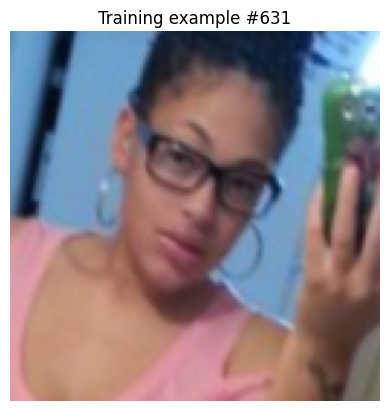

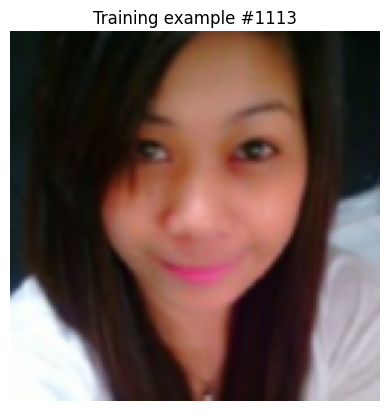

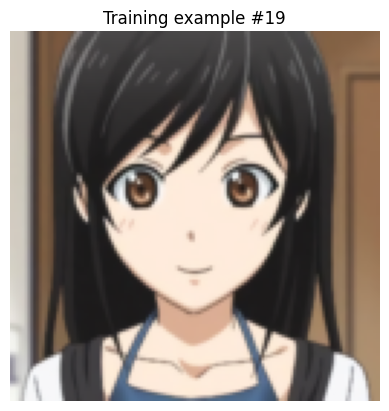

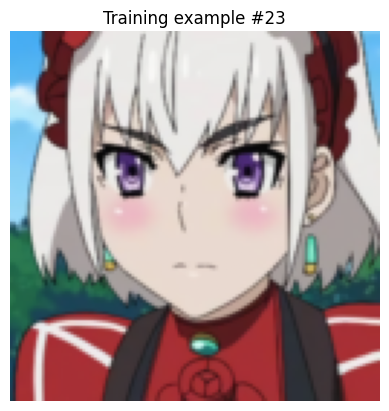

In [16]:
# Visualize a couple of images from the anime and face datasets
def visualize_samples(dataset, num_samples):
    for _ in range(num_samples):
        random_seg_img = random.randint(0, len(dataset))
        img, _ = dataset[random_seg_img]
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Training example #{random_seg_img}")
        plt.axis('off')
        plt.show()
visualize_samples(realFacesTrain, 2)
visualize_samples(animeFacesTest, 2)



# Constructing the Generative Model

In [17]:
# Generative Model
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.num_channels = num_channels
        self.single_residual_block = nn.Sequential(
            nn.Conv2d(self.num_channels, self.num_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(self.num_channels),
            nn.ReLU(),
            nn.Conv2d(self.num_channels, self.num_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(self.num_channels),
            nn.ReLU() # This could optionally be taken away?
        )
    def forward(self, x):
        return x + self.single_residual_block(x)

class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        
        # Downsampling layers
        self.downSampleLayers = nn.Sequential(
            nn.Conv2d(in_channels =3, out_channels = 64, kernel_size = 7, stride = 1, padding = 3, padding_mode = "reflect"),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels = 128, kernel_size = 3, stride =2, padding=1, padding_mode = "reflect"),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels = 256, kernel_size = 3, stride =2, padding=1, padding_mode = "reflect"),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        )
        # At the end of downsampling, input is 32x32x256

        # 6 residual blocks, as recommended in the paper for 128 x 128 images
        self.residualLayers = nn.Sequential( # maybe should be module list?
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Upsampling layers
        self.upSampleLayers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        )
        # At the end of upsampling layers input is 128x128x64

        # Final layer, reverts back to 3 color channels. Output is 128x128x3
        self.out = nn.Conv2d(64, 3, 7, 1, 3, padding_mode= "reflect")

    def forward(self, x):
        x = self.downSampleLayers(x)
        x = self.residualLayers(x)
        x = self.upSampleLayers(x)
        x = self.out(x)
        return x
        

# Constructing the Discriminator Model

In [18]:
# Discriminative Model

class DiscriminativeModel(nn.Module):
    def __init__(self):
        super(DiscriminativeModel, self).__init__()
        
        # Discriminator Layers
        self.discriminatorLayers = nn.Sequential(
            nn.Conv2d(in_channels =3, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            # No instance norm for the first layer, as the cycleGan paper suggests
            nn.LeakyReLU(0.2),
            # Output is 64x64x64

            nn.Conv2d(in_channels =64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            # Output is 32x32x128

            nn.Conv2d(in_channels =128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            # Output is 16x16x256

            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            # Output is 8x8x512
        )

        self.out = nn.Sequential(
            nn.Conv2d(512, 1, 4,1,1, padding_mode="reflect"),
            nn.Sigmoid() 
        )
        # Results in a binary label

    def forward(self, x):
        x = self.discriminatorLayers(x)
        x = self.out(x)
        return x

In [19]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Save a model
def saveModel(model, optimizer, epochs, location):
    to_save = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "numEpochs": epochs
    }
    torch.save(to_save, location)

# Load a model
def loadModel(model, optimizer, lr, location):
    to_load = torch.load(location)
    model.load_state_dict(to_load["state_dict"])
    optimizer.load_state_dict(to_load["optimizer"])
    numEpochs = int(to_load["numEpochs"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return numEpochs

# Training

In [20]:
# Training
def train(realFaceLoader, animeFaceLoader, genRealModel, genAnimeModel, discRealModel, discAnimeModel, genOpt, discOpt, genScaler, discScaler, lambdaVal = 10, epochs=100,  startingEpochs = 0):
    mseLoss = nn.MSELoss()
    l1Loss = nn.L1Loss()
    print(DEVICE)

    anime_originals = 0
    anime_fakes = 0
    
    genRealModel.train()
    genAnimeModel.train()
    discRealModel.train()
    discAnimeModel.train()
    
    for e in range(epochs):
        
        animeFaceIterator = iter(animeFaceLoader)
        for idx, (realFace, _) in enumerate(realFaceLoader):
            animeFace = next(animeFaceIterator)[0]
            animeFace = animeFace[0]
            realFace = realFace[0]
            realFace = realFace.to(DEVICE)
            animeFace = animeFace.to(DEVICE)

            # Training discriminators
            with torch.cuda.amp.autocast():
                generatedAnimeFace = genAnimeModel(realFace)
                animeDiscOnGenerated = discAnimeModel(generatedAnimeFace.detach())
                animeDiscOnAnime = discAnimeModel(animeFace) # detatch() was here
                anime_originals += animeDiscOnAnime.mean().item()
                anime_fakes += animeDiscOnGenerated.mean().item()
                animeDiscOriginalLoss = mseLoss(animeDiscOnAnime, torch.ones_like(animeDiscOnAnime))
                animeDiscGeneratedLoss = mseLoss(animeDiscOnGenerated, torch.ones_like(animeDiscOnGenerated))
                animeDiscriminatorLoss = animeDiscOriginalLoss + animeDiscGeneratedLoss 

                generatedRealFace = genRealModel(animeFace)
                realDiscOnGenerated = discRealModel(generatedRealFace.detach()) # detatch() was here
                realDiscOnOriginal = discRealModel(realFace)
                realDiscOriginalLoss = mseLoss(realDiscOnOriginal, torch.ones_like(realDiscOnOriginal))
                realDiscGeneratedLoss = mseLoss(realDiscOnGenerated, torch.ones_like(realDiscOnGenerated))
                realDiscriminatorLoss = realDiscOriginalLoss + realDiscGeneratedLoss

                discriminatorLoss = (animeDiscriminatorLoss + realDiscriminatorLoss) / 2

            discOpt.zero_grad()
            discScaler.scale(discriminatorLoss).backward()
            discScaler.step(discOpt)
            discScaler.update()

            # Train generators
            with torch.cuda.amp.autocast():

                # Losses from discriminators
                discAnimeGenerated = discAnimeModel(generatedAnimeFace)
                discRealGenerated = discRealModel(generatedRealFace)
                lossGeneratedAnime = mseLoss(discAnimeGenerated, torch.ones_like(discAnimeGenerated))
                lossGeneratedReal = mseLoss(discRealGenerated, torch.ones_like(discRealGenerated))

                # Losses from cycling
                cycledAnimeFace = genAnimeModel(generatedRealFace)
                cycledRealFace = genRealModel(generatedAnimeFace)
                lossCycledAnimeFace = l1Loss(animeFace, cycledAnimeFace) * lambdaVal
                lossCycledRealFace = l1Loss(realFace, cycledRealFace) * lambdaVal

                generatorLoss = lossGeneratedAnime + lossGeneratedReal + lossCycledAnimeFace + lossCycledRealFace

            genOpt.zero_grad()
            genScaler.scale(generatorLoss).backward()
            genScaler.step(genOpt)
            genScaler.update()

            if idx % 250 == 0:
                print(f"Currently on epoch: {e + startingEpochs}, index: {idx}")

        saveModel(genRealModel, genOpt, e + startingEpochs, "savedModels/genRealModel")
        saveModel(genAnimeModel, genOpt, e + startingEpochs, "savedModels/genAnimeModel")
        saveModel(discRealModel, discOpt, e + startingEpochs, "savedModels/discRealModel")
        saveModel(discAnimeModel, discOpt, e + startingEpochs, "savedModels/discAnimeModel")
        print(f"SAVED EPOCH {e + startingEpochs} MODEL!")


In [37]:
SAVED_MODELS_EXIST = False

animeFaceGenerator = GeneratorModel().to(DEVICE)
realFaceGenerator = GeneratorModel().to(DEVICE)
animeFaceDiscriminator = DiscriminativeModel().to(DEVICE)
realFaceDiscriminator = DiscriminativeModel().to(DEVICE)

genOpt = optim.Adam(list(animeFaceGenerator.parameters()) + list(realFaceGenerator.parameters()), lr= 0.0002, betas = (0.9,0.999))
discOpt = optim.Adam(list(animeFaceDiscriminator.parameters()) + list(realFaceDiscriminator.parameters()), lr= 0.0002, betas = (0.9,0.999))

curNumEpochs = 0
if SAVED_MODELS_EXIST:
    curNumEpochs = loadModel(realFaceGenerator, genOpt, 0.0002, "savedModels/genRealModel")
    loadModel(animeFaceGenerator, genOpt, 0.0002, "savedModels/genAnimeModel")
    loadModel(realFaceDiscriminator, discOpt, 0.0002, "savedModels/discRealModel")
    loadModel(animeFaceDiscriminator, discOpt, 0.0002, "savedModels/discAnimeModel")
    print("LOADED SAVED MODELS")

genScaler = torch.cuda.amp.GradScaler()
discScaler = torch.cuda.amp.GradScaler()

train(realFacesTrainLoader, animeFacesTrainLoader, realFaceGenerator, animeFaceGenerator, realFaceDiscriminator, animeFaceDiscriminator, genOpt, discOpt, genScaler, discScaler, startingEpochs = curNumEpochs)

LOADED SAVED MODELS
cuda:0
Currently on epoch: 0, index: 0


KeyboardInterrupt: 

# Visualizing Results

cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


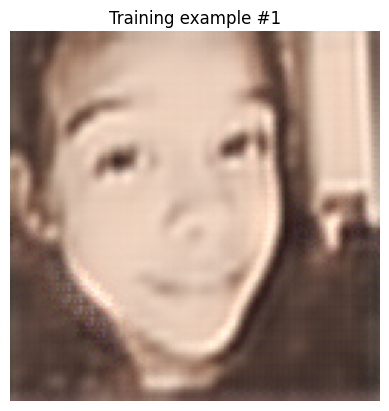

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


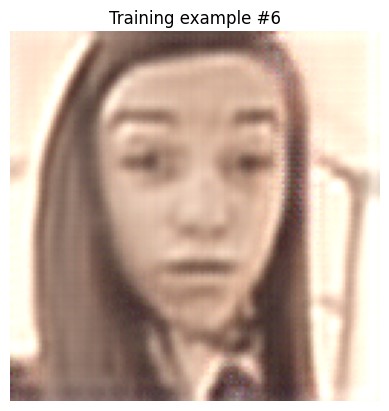

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


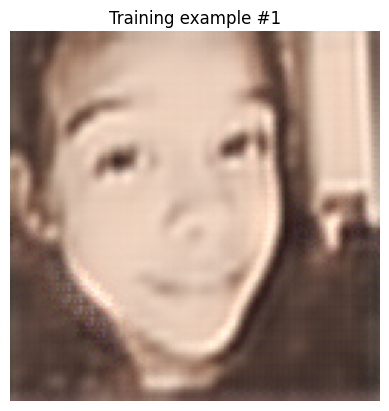

In [36]:
# Code to visualize results
def visualize_generated(listOfGenerated, num_samples):
    for _ in range(num_samples):
        random_seg_img = random.randint(0, len(listOfGenerated))
        img = listOfGenerated[random_seg_img]
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Training example #{random_seg_img}")
        plt.axis('off')
        plt.show()

print(DEVICE)
animeFaceGenerator = GeneratorModel().to(DEVICE)
genOpt = optim.Adam(list(animeFaceGenerator.parameters()) + list(realFaceGenerator.parameters()), lr= 0.0002, betas = (0.9,0.999))

loadModel(animeFaceGenerator, genOpt, 0.0002, "savedModels/genAnimeModel")

animeFaceGenerator.eval()
generatedAnimeFaces = []
for idx, (realFace, _) in enumerate(realFacesTestLoader):
    if idx % 10 == 0:
        realFace = realFace[0]
        realFace = realFace.to(DEVICE)
        generated_face = animeFaceGenerator(realFace)
        generatedAnimeFaces.append(generated_face.detach().cpu())
        
visualize_generated(generatedAnimeFaces, 2)
